# 03 - Preprocessing & Model Training 🤖

## Problem

How can we generate short descriptions including a list of popular beer styles from brewery reviews with natural language processing (NLP)? 

NOTE: This is similar to how Google Maps provides short blurbs for businesses such as “From scratch, Northern Italian dining.” 

For example, "Spacious warehouse brewery with daily food trucks. Allows dogs. Features IPAs, Hazy IPAs, and high-gravity stouts."

## Notebook Objectives

* Understand the importance of creating a model training development data set.
* Correctly identify when to create dummy features or one-hot encoded features.
* Understand the importance of magnitude standardization.
* Apply the train and test split to the development dataset effectively.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import time
import math
from pprint import pprint

import random
random.seed(42)

# Progress bar
# from tqdm import tqdm, trange
from tqdm.notebook import tqdm, trange

# NLP Toolkit
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding, decaying

%matplotlib inline

In [2]:
# Set default plot size
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
# Load small English language model for sentence separation.
nlp = spacy.load("en_core_web_sm")

In [4]:
# Load data
df = pd.read_csv('../data/raw/brewery_reviews.csv', index_col=0, parse_dates=['date'])
df.head()

,review_text,rating,date,brewery_name,street,city,tokens,sents
0,Got to visit the newest brewery in Birmingham ...,4.13,2019-07-25,Birmingham District Brewing,"2201 2nd Ave S, Ste 102",Birmingham,110,8
1,"Nice big space, very clean, and friendly staff...",4.04,2018-10-23,Trimtab Brewing Company,2721 5th Ave S,Birmingham,105,7
2,The vibe of trim tab is interesting.....they h...,4.04,2018-08-24,Trimtab Brewing Company,2721 5th Ave S,Birmingham,116,9
3,"Stopped here late one night before closing, th...",4.07,2017-07-11,Trimtab Brewing Company,2721 5th Ave S,Birmingham,74,5
4,Extremely relaxed brewery. Great service with ...,4.10,2018-01-21,Trimtab Brewing Company,2721 5th Ave S,Birmingham,33,5


In [5]:
# We don't need reviews without text for this work
df.dropna(inplace=True)

In [6]:
# Count sentences
df['sents'].sum()

194504

In [7]:
# Separate reviews into sentences for annotation.
# WARNING: THIS TAKES A LONG TIME (~8 minutes)
start_time = time.time()

sentence_list = []
for review in df['review_text']:
    doc = nlp(review)
    for sent in doc.sents:
        sentence_list.append(sent.text)
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 554.999528169632 seconds ---


In [12]:
# Get sentence length (i.e. number of tokens per sentence)
sentence_length = [len(sent) for sent in sentence_list]

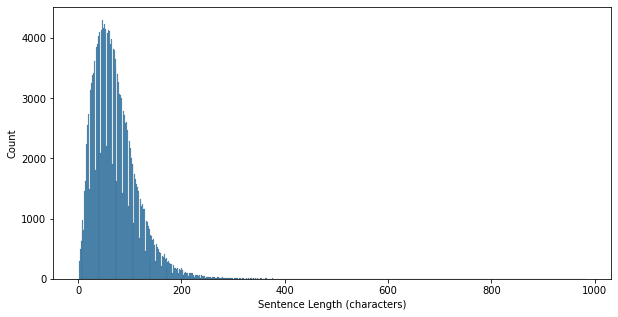

In [13]:
# Visualize
sns.histplot(data=sentence_length)
plt.ylabel('Count')
plt.xlabel('Sentence Length (characters)')
plt.show()

In [14]:
# Create DataFrame of sentence
sent_df = pd.DataFrame(sentence_length)

In [15]:
# Inspect
sent_df.describe()

,0
count,194504.000000
mean,71.953297
std,44.211408
min,1.000000
25%,41.000000
50%,64.000000
75%,94.000000
max,983.000000


In [18]:
def find_outliers(array):
    """
    Returns a tuple of (lower, upper) cut-offs so you can do something like:
    `sent_list_cleaned = [sent for sent in sent_list if len(sent) >= lower and len(sent) <= upper]`
    """
    data = np.array(array)
    # calculate interquartile range
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    print(f'Percentiles: 25th={q25}, 75th={q75}, IQR={iqr}')
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25, q75 + cut_off
    print(f'Cut-offs: lower={lower}, upper={upper}')
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    print(f'Identified outliers: {len(outliers)}')
    # remove outliers
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    print(f'Non-outlier observations: {len(outliers_removed)}')
    
    return lower, upper

In [19]:
lower, upper = find_outliers(sentence_length)

Percentiles: 25th=41.0, 75th=94.0, IQR=53.0
Cut-offs: lower=41.0, upper=173.5
Identified outliers: 54088
Non-outlier observations: 140416


In [20]:
# Create list of sentences of a non-outlier length
sents_cleaned = [sent for sent in sentence_list if len(sent) >= lower and len(sent) <= upper]

In [21]:
# Write random sentences to text file for import into Doccano
sents_np = np.array(sents_cleaned)
sizes = [100, 500, 1000, 5000]

for size in sizes:
    random_sents = np.random.choice(sents_np, size=size, replace=False)
    with open(f'../data/processed/brewery-review-sentences-{size}.txt','w') as write:
        write.write("\n".join(random_sents))

## Full Review Text vs. Sentences

After loading 500 sentences into Doccano and starting to annotate, I realized the context may be more helpful from a user experience perspective and useful for a model training persepctive.

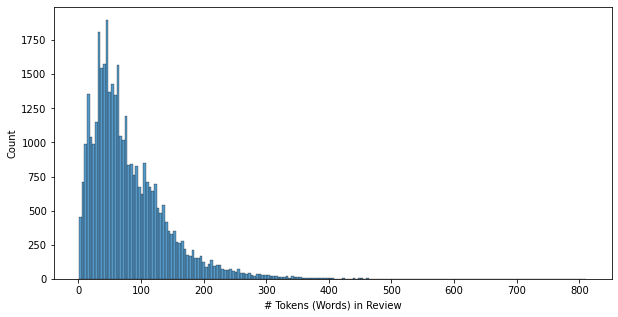

In [22]:
sns.histplot(data=df, x='tokens')
plt.xlabel('# Tokens (Words) in Review')
plt.ylabel('Count')
plt.show()

In [23]:
lower, upper = find_outliers(df['tokens'])

Percentiles: 25th=38.0, 75th=110.0, IQR=72.0
Cut-offs: lower=38.0, upper=218.0
Identified outliers: 10639
Non-outlier observations: 26895


In [24]:
df_cleaned = df[(df['tokens'] >= lower) & (df['tokens'] <= upper)]
len(df_cleaned)

26895

In [25]:
# Write random sentences to text file for import into Doccano
reviews_np = np.array(df_cleaned['review_text'])
sizes = [100, 500, 1000, 5000]

for size in sizes:
    random_reviews = np.random.choice(reviews_np, size=size, replace=False)
    with open(f'../data/processed/brewery-reviews-{size}.txt','w') as write:
        write.write("\n".join(random_reviews))

## Model Training v1

In [26]:
# Load the TRAIN_DATA from the Doccano export
filename = ("../data/annotations/export-reviews-100-v2.json")
TRAIN_DATA = []

with open(filename) as file:
    lines = file.readlines()
    for train_data in lines:
        data = json.loads(train_data)
        if len(data['labels']) == 0 and data['annotation_approver'] == None: continue
        ents = [tuple(entity[:3]) for entity in data['labels']]
        TRAIN_DATA.append((data['text'],{'entities':ents}))

with open('{}'.format(filename.replace('json','txt')),'w') as write:
    write.write(str(TRAIN_DATA))

print("[INFO] Stored the spacy training data and filename is {}".format(filename.replace('json','txt')))

[INFO] Stored the spacy training data and filename is ../data/annotations/export-reviews-100-v2.txt


In [27]:
# Load the LABELS from the Doccano export
labels_filename = ("../data/processed/brewery-review-labels.json")
LABELS = []

with open(labels_filename) as file:
    labels = json.load(file)
    LABELS = [label['text'] for label in labels]
    
print(LABELS)

['Feature', 'Beer Style', 'Location']


In [28]:
# Load existing Language model and add the LABELS 

# Load existing model
# model = "en_core_web_sm"

# nlp = spacy.load(model)
# print(f"Loading model '{model}'")

# Alternate: Create blank Language class
nlp = spacy.blank("en")
print("Created blank 'en' model")

# Either add NER to pipeline or grab it so we can add labels
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
else:
    ner = nlp.get_pipe("ner")

for label in LABELS:
    print(f"Adding LABEL '{label}'")
    ner.add_label(label)

Created blank 'en' model
Adding LABEL 'Feature'
Adding LABEL 'Beer Style'
Adding LABEL 'Location'


In [29]:
# Train the model

# Number of iterations
n_iter=200

# Drop to prevent over-fitting
drop = decaying(0.6, 0.2, 1e-4)

# Set optimizer and begin training
optimizer = nlp.begin_training()

# Minibatch sizes
sizes = compounding(1.0, 4.0, 1.001)

loss = []

pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
# only train NER
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    # show warnings for misaligned entity spans once
    warnings.filterwarnings("once", category=UserWarning, module='spacy')

    # batch up the examples using spaCy's minibatch
    # NOTE: These are defaults from https://spacy.io/usage/training#ner
    with trange(n_iter) as pbar:
        for _ in pbar:
            # Randomize the training data
            random.shuffle(TRAIN_DATA)

            # Create batches
            batches = minibatch(TRAIN_DATA, size=sizes)

            # Train and update
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=next(drop), losses=losses)

            # Logging
            loss.append(losses['ner'])
            pbar.set_postfix(loss=losses['ner'])

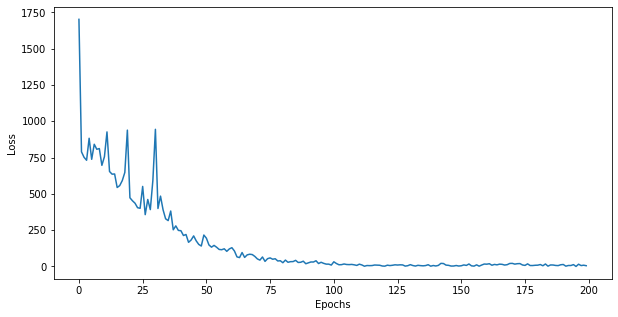

In [30]:
plt.plot(range(n_iter), loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Model Training v2

1. Load in annotations from Doccano
2. Randomize and split into train and test sets
3. Use spacy CLI to train and save model

### Reference

* https://medium.com/@justindavies/training-spacy-ner-models-with-doccano-8d8203e29bfa

In [31]:
# Load the annotations from the Doccano export

filename = ("../data/annotations/export-reviews-100-v2.json")

# Array of tuples [(TEXT, {'entities': ENTITIES[]})]
DATA = []

with open(filename) as file:
    lines = file.readlines()
    for annot_data in lines:
        data = json.loads(annot_data)
        
        # Ignore annotations without labels and no approval
        if len(data['labels']) == 0 and data['annotation_approver'] == None: continue

        # Create entities and append
        ents = [tuple(entity[:3]) for entity in data['labels']]
        DATA.append((data['text'], {'entities': ents}))

print(f"Number of examples: {len(DATA)}")

Number of examples: 100


In [33]:
# Convert Doccano JSONL to spaCy-compatible JSONL

filename = ("../data/annotations/export-reviews-100-v2.json")

with open(filename) as file:
    lines = file.readlines()
    
    for line in lines:
        line = json.loads(line)
        
        # Ignore annotations without labels and no approval
        if len(line['labels']) == 0 and line['annotation_approver'] == None: continue
        
        # Rename "labels" to "entities"
        if "labels" in line:
            line["entities"] = line.pop("labels")
        else:
            line["entities"] = []

        # Reorganize the entities
        tmp_ents = []
        for entity in line["entities"]:
            if entity[2] in LABELS:
                tmp_ents.append({"start": entity[0], "end": entity[1], "label": entity[2]})
            line["entities"] = tmp_ents
        
        with open(filename.replace('.json','-spacy.jsonl'), 'a+') as write:
            write.write(json.dumps({"entities": line["entities"], "text": line["text"]}))
            write.write("\n")

In [34]:
# Randomize and split into train and test
filename = ("../data/annotations/export-reviews-100-v2-spacy.jsonl")

with open(filename) as file:
    DATA = file.readlines()

random.shuffle(DATA)
n = math.floor(0.9 * len(DATA))
train_data = DATA[:n]
test_data = DATA[n:]

print(f"train: {len(train_data)}")
print(f"test: {len(test_data)}")

train: 90
test: 10


In [35]:
train_filename = "../data/annotations/export-reviews-100-v2-spacy-train.jsonl"
test_filename = "../data/annotations/export-reviews-100-v2-spacy-dev.jsonl"

with open(train_filename, 'w') as write:
    write.write("".join(train_data))

print("[INFO] Stored the spacy training data at {}".format(train_filename))

with open(test_filename, 'w') as write:
    write.write("".join(test_data))

print("[INFO] Stored the spacy dev data at {}".format(test_filename))

[INFO] Stored the spacy training data at ../data/annotations/export-reviews-100-v2-spacy-train.jsonl
[INFO] Stored the spacy dev data at ../data/annotations/export-reviews-100-v2-spacy-dev.jsonl


In [36]:
# Convert JSONL to spaCy JSON
# python -m spacy convert export-reviews-100-v2-spacy-train.jsonl ./ --lang en
# python -m spacy convert export-reviews-100-v2-spacy-dev.jsonl ./ --lang en

# Train model
# python -m spacy train en model ./export-reviews-100-v2-spacy-train.json ./export-reviews-100-v2-spacy-dev.json -b en_core_web_sm -p ner

# Evaluate model
# python -m spacy evaluate models/model-final data/annotations/export-reviews-100-v2-spacy-dev.json --displacy-path reports/displacy

In [38]:
# Load saved model
nlp = nlp.from_disk("../models/v1/model-final")

In [39]:
# Test trained model with real data
with open('../data/raw/reviews_san-diego_half-door-brewing-co.txt') as file:
    reviews = file.readlines()

colors = {"FEATURE": "#80CBC4", "BEER STYLE": "#FDD835", "LOCATION": "#9FA8DA"}
options = {"colors": colors} 
    
for review in reviews:
    doc = nlp(review)
    displacy.render(doc, style="ent", options=options)

/Users/chris/opt/anaconda3/envs/brewery-review-nlp/lib/python3.9/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [40]:
# Test trained model
with open('../data/raw/reviews_san-diego_alesmith.txt') as file:
    reviews = file.readlines()

colors = {"FEATURE": "#80CBC4", "BEER STYLE": "#FDD835", "LOCATION": "#9FA8DA"}
options = {"colors": colors} 
    
for review in reviews:
    doc = nlp(review)
    displacy.render(doc, style="ent", options=options)